# Part I: Small-scale QAQO

## Classical maximum-cut problem

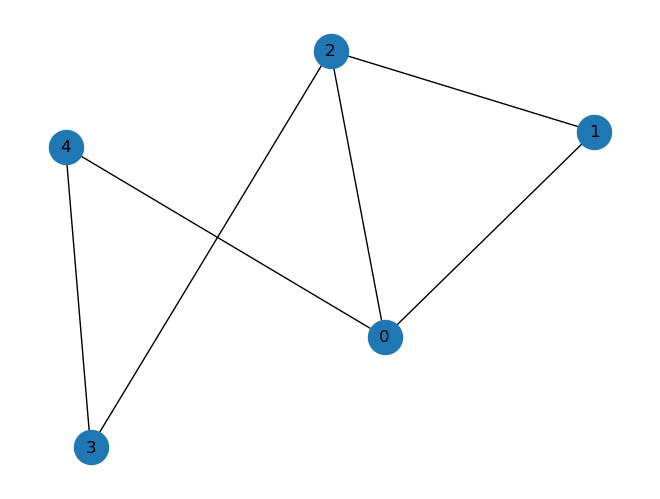

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### Mapping classical inputs to a quantum problem

#### Definiting a cost function in terms of a Hamiltonian using Quadratic Unconstrained Binary Optimization (QUBO) problems notation

\begin{align}\min_{x\in{0,1}^{n}} f(x) \rightarrow \min_{x\in{0,1}^{n}} x^{T}Qx \iff \min_{x\in{-1,1}^{n} z^{T}Qz + b^{T}z}\end{align}

where $Q\in \mathbb{R}^{n\times n}$, $n:$ number of nodes, $b = -\sum_{j}(Q_{ij}+Q_{ji})$.

let: $f_{i,j}(x) = x_{i} + x_{j} - 2x_{i}x_{j},\:\: F(x) = \sum_{i,j} f_{i,j}(x)$

$\implies H_{C} = \sum_{i,j}Q_{ij}Z{i}Z_{j} + \sum_{i}b_{i}Z_{i}$

In [3]:
from qiskit.quantum_info import SparsePauliOp

# Defining the cost function Hamiltonian 
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
        
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))
        
    return pauli_list 

max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost function Hamiltonian: ", cost_hamiltonian)

Cost function Hamiltonian:  SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


#### Two-parameter QAOA

$H^{\otimes n}|0\rangle \rightarrow e^{-i\gamma_{k}H_{C}}, e^{-i\beta_{k}H_{m}}$


Parameters: $\gamma_{1}, \beta_{1}$

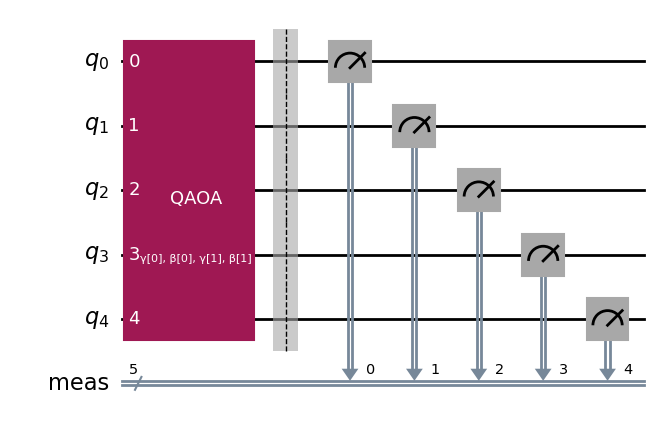

In [4]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [5]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Optimization for quantum execution

<IBMBackend('ibm_sherbrooke')>


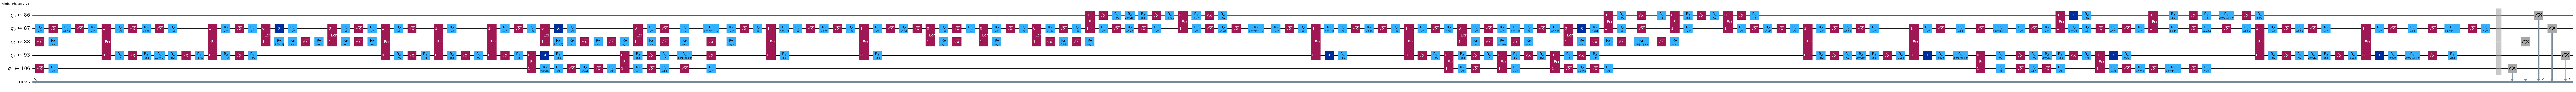

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

### Execution using Qiskit primitives

In [7]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [16]:
# Defining the cost function expectation value
def cost_func_estimator(params, ansatz, hamiltonian, estimator): 
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    
    #pub = (ansatz, isa_hamiltonian, params)
    #job = estimator.run([pub])
    job_id = "cvzn8xb61ph0008jwtcg"
    job = service.job(job_id)

    
    results = job.result()[0]
    cost = results.data.evs
    
    objective_func_vals.append(cost)
    
    return cost 

In [17]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize 

objective_func_vals = []
with Session(backend=backend) as session: 
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
    
    # Error suppression
    estimator.options.dynamical_decoupling.enable = True 
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True 
    estimator.options.twirling.num_randomizations = "auto"
    
    result = minimize(cost_func_estimator, init_params, args=(candidate_circuit, cost_hamiltonian, estimator), method="COBYLA", tol=1e-3,)
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.0786858415914526
       x: [ 3.142e+00  1.571e+00  3.142e+00  1.571e+00]
    nfev: 17
   maxcv: 0.0


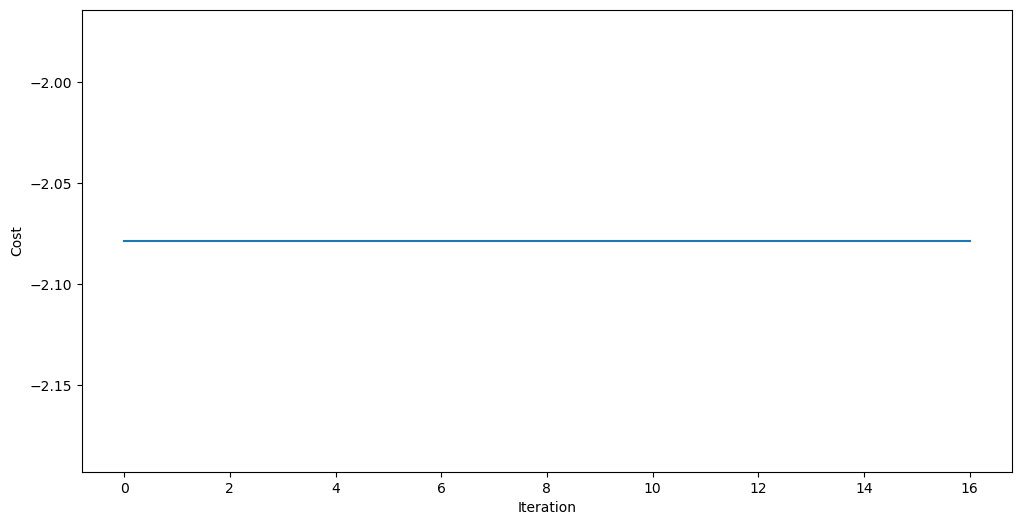

In [18]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

### Sample the final distribution

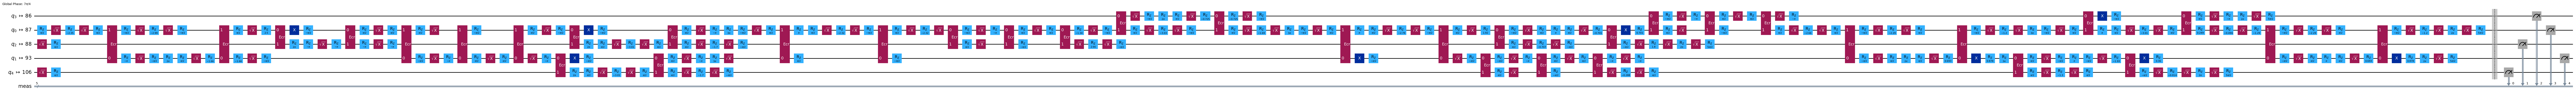

In [19]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [21]:
from qiskit_ibm_runtime import SamplerV2 as Sampler 

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Error suppression
sampler.options.dynamical_decoupling.enable = True 
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True 
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{23: 0.033, 5: 0.0277, 31: 0.0342, 22: 0.0305, 28: 0.032, 29: 0.0289, 30: 0.0351, 17: 0.0292, 19: 0.0321, 24: 0.0285, 6: 0.0307, 27: 0.0341, 20: 0.03, 15: 0.0364, 8: 0.0327, 18: 0.0317, 2: 0.0281, 25: 0.0311, 26: 0.0349, 10: 0.0342, 21: 0.0291, 16: 0.0277, 9: 0.0317, 4: 0.0307, 7: 0.0284, 1: 0.0316, 11: 0.0338, 13: 0.0329, 3: 0.0289, 14: 0.0336, 12: 0.0265, 0: 0.03}


### Post-processing

In [22]:
# Auxiliary function to sample most probable bitstring
def to_bitstring(integer, num_bits): 
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Resultant bitstring: ", most_likely_bitstring)

Resultant bitstring:  [1, 1, 1, 1, 0]


/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_63779/3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


TypeError: only length-1 arrays can be converted to Python scalars

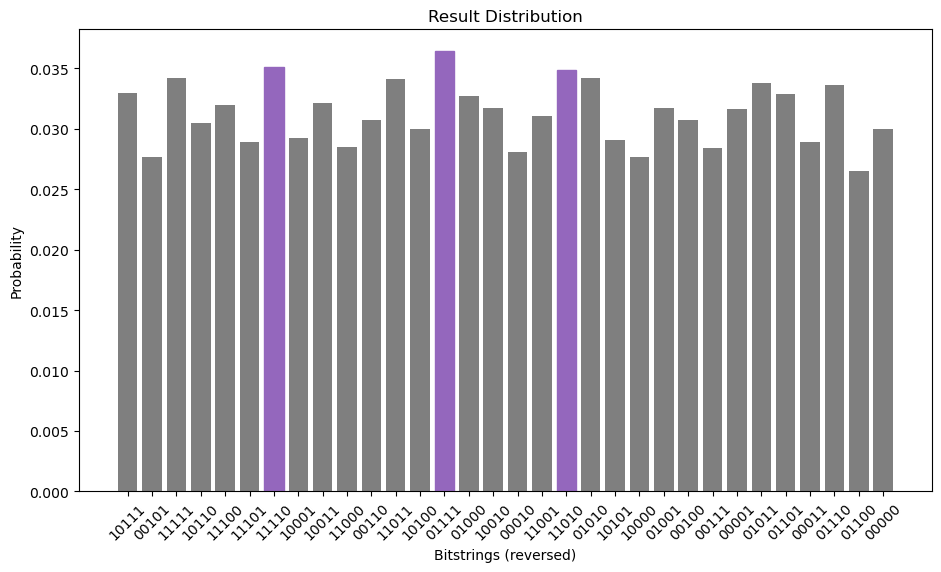

In [24]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

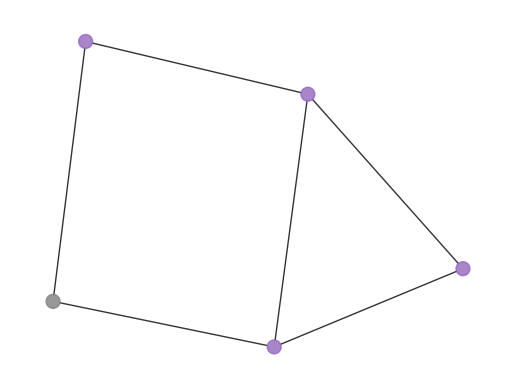

In [25]:
# Auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [26]:
from typing import Sequence

def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 2


Note: The execution on the QPU was interrupted when running this code. However, the ideal output would produce a Hamiltonian with value of the cut = 5 and a more varied probabilities histogram. 

# Part II: Large-scale QAOA

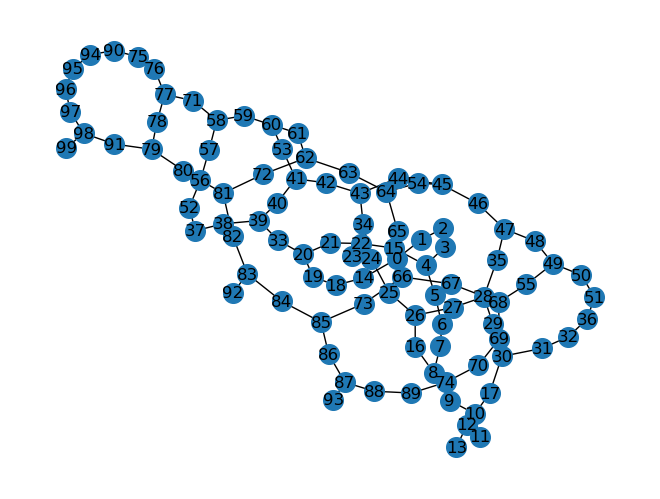

In [28]:
n = 100 # number of nodes in the graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []

for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
    
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

### Mapping graph to a Hamiltonian

In [30]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost function Hamiltonian: ", cost_hamiltonian_100)

Cost function Hamiltonian:  SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIII

### Mapping Hamiltonian to a quantum circuit

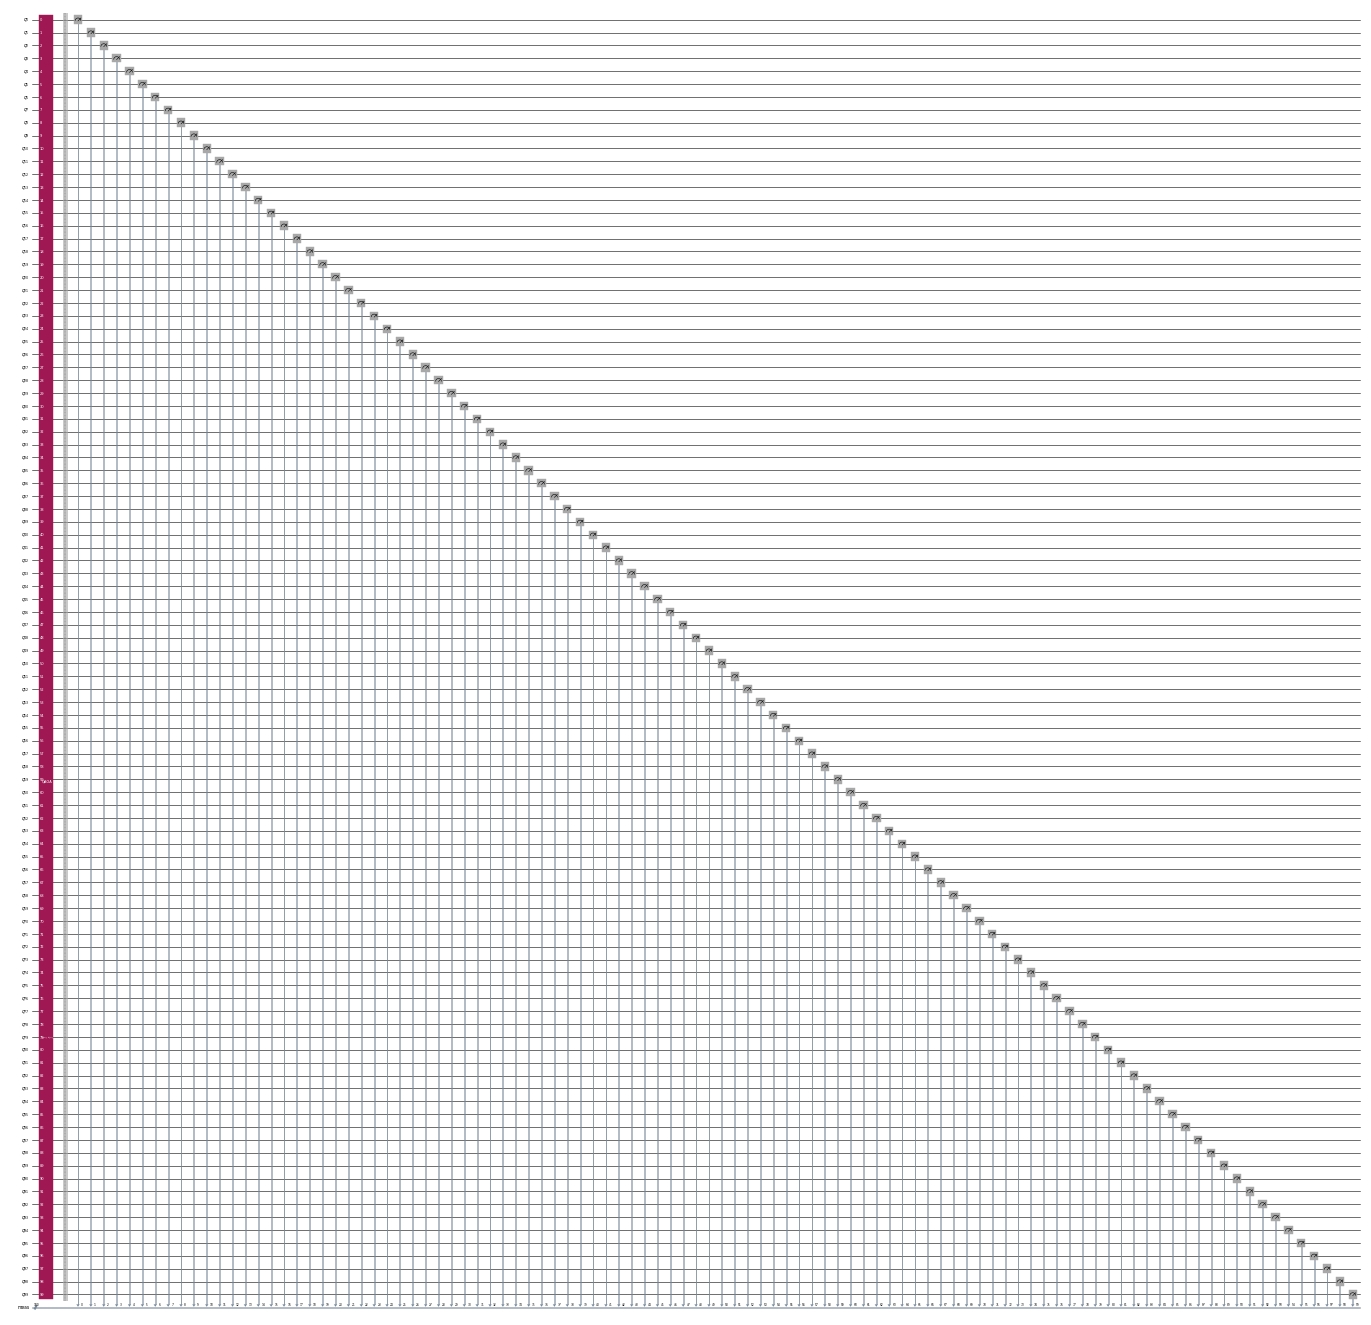

In [31]:
circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

### Optimization for quantum execution 

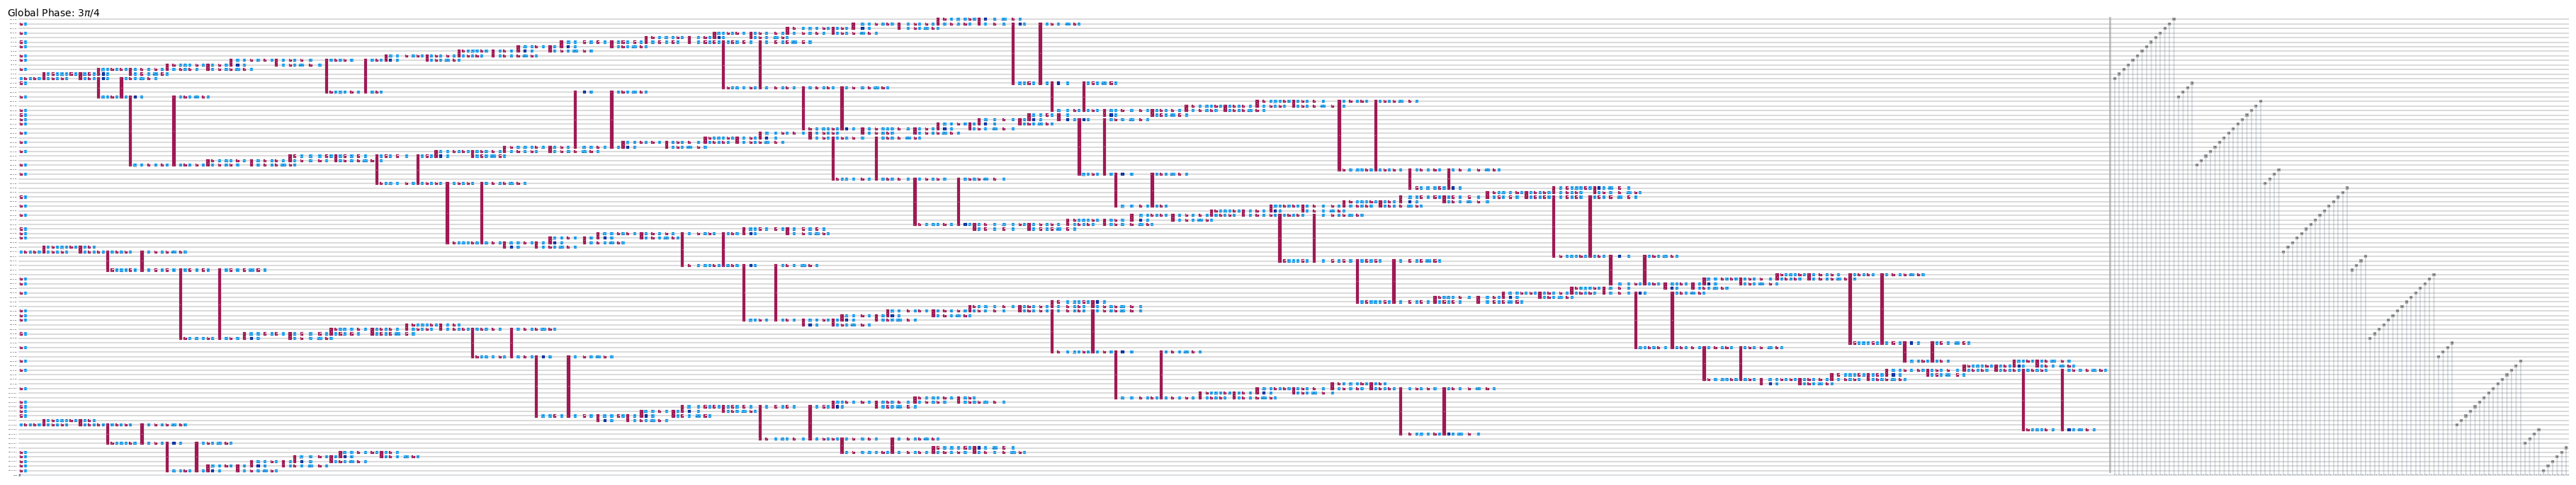

In [32]:
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

### Quantum Execution

In [33]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

objective_func_vals = [] 
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
    
    # Error suppression
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(cost_func_estimator, init_params, args=(candidate_circuit_100, cost_hamiltonian_100, estimator), method="COBYLA",)
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.0786858415914526
       x: [ 3.142e+00  1.571e+00]
    nfev: 13
   maxcv: 0.0


In [34]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw('mpl', fold=False, idle_wires=False)

### Sample final distribution

In [35]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Error suppression
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_100, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}

### Post-processing

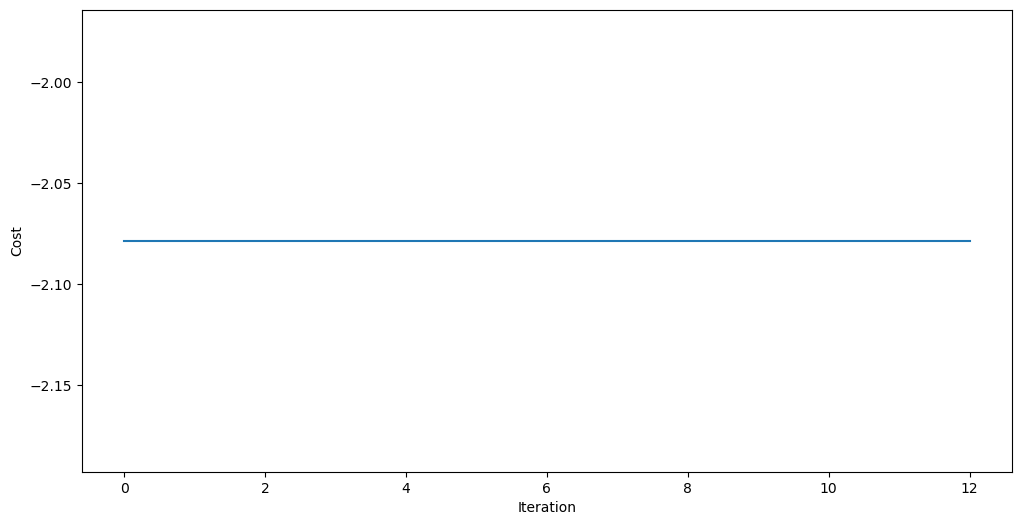

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [39]:
# Extracting lowest-cost solution
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)

def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex: 
    # Evaluation of the expectation value of a measured state
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol
            
    return min_sol

best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

Result bitstring: [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


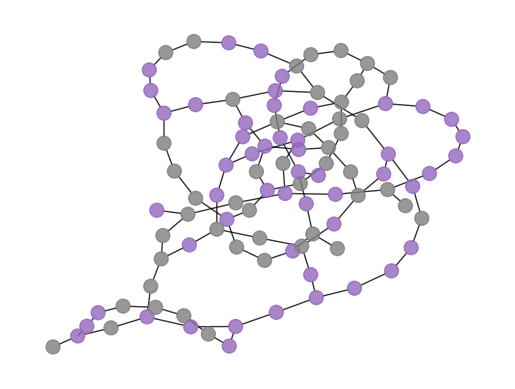

In [40]:
plot_result(graph_100, best_sol_bitstring_100)

In [41]:
cut_value_100= evaluate_sample(best_sol_bitstring_100, graph_100)
print('The value of the cut is:', cut_value_100)

The value of the cut is: 49


In [44]:
from collections import defaultdict

# Computing objective value of each sample to determine solution

# Auxiliary function to plot cumulative distribution function
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)
    
def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1")
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")
    
    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative Distribution Function")
    ax.grid(alpha=0.3)
    
# Auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob
        
    return objective_values

result_dist = samples_to_objective_values(final_distribution_100_int, cost_hamiltonian_100)

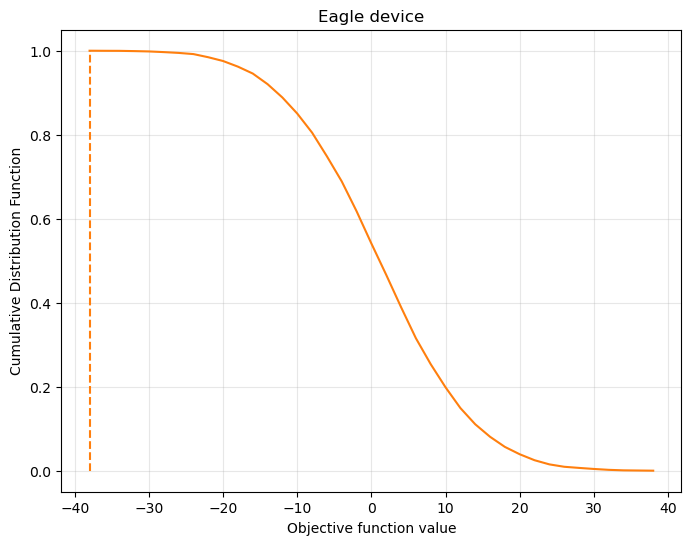

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")